# Doc 11 - Densenet com classificação binária

A partir dos testes que foram feitos nas documentações passadas, é perceptível que a rede não tem sido capaz de classificar bem todas as classes da base dados que estamos trabalhando com. 

Com isso, vamos tentar realizar os mesmos testes utilizando a DenseNet com transfer learning, mas agora usando uma classificação binária (Cancer type e Normal).

In [1]:
import setuptools.dist
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from PIL import Image
import matplotlib.pylab as plt
import pandas as pd
import os
import shutil
import numpy as np
import seaborn as sns

# 1 - Visualização de dados

In [2]:
#Função para visualização
def plot_image_counts(folder_path):
    #Contadores pra plotar
    counts = {'actionable': 0, 'benign': 0, 'cancer': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue', 'green', 'red', 'purple'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

In [3]:
#Função para visualização
def plot_image_counts2(folder_path):
    #Contadores pra plotar
    counts = {'cancer_type': 0, 'normal': 0}

    #Vai olhar os folders
    total_images = 0
    for class_name in counts.keys():
        class_path = os.path.join(folder_path, class_name)
        if os.path.exists(class_path):
            class_count = len(os.listdir(class_path))
            counts[class_name] = class_count
            total_images += class_count

    #Cálculo da porcentagem
    percentages = {class_name: count / total_images * 100 for class_name, count in counts.items()}

    #Plot dos gráficos
    plt.figure(figsize=(10, 6))
    plt.bar(percentages.keys(), percentages.values(), color=['blue',  'red'])
    plt.xlabel('Classe')
    plt.ylabel('Porcentagem')
    plt.title('Porcentagem de imagens em cada classe')
    plt.show()

    #Tabelinha
    df = pd.DataFrame({'Quantidade': counts.values(), 'Porcentagem': percentages.values()}, index=counts.keys())
    print("Tabela quantidade-porcentagem:")
    print(df)

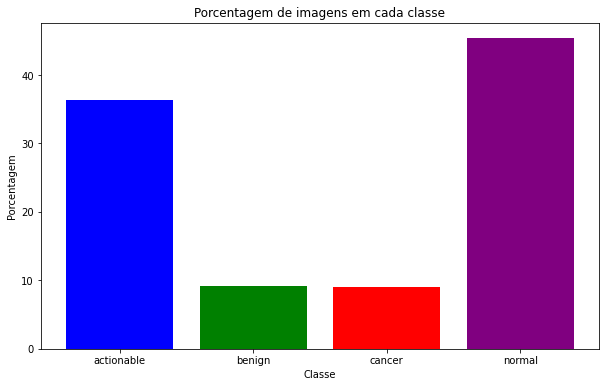

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         240    36.308623
benign              61     9.228442
cancer              60     9.077156
normal             300    45.385779


In [4]:
#Test set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\test'
plot_image_counts(folder_path)

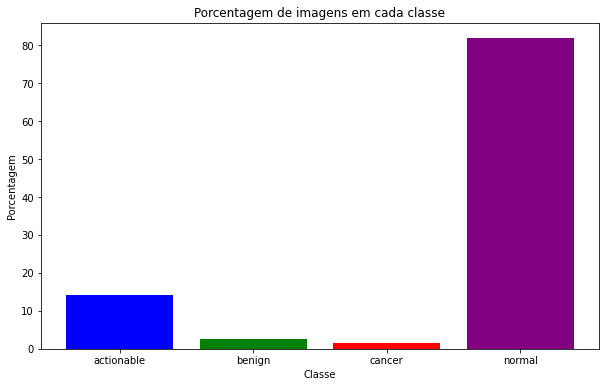

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         712    14.180442
benign             124     2.469628
cancer              76     1.513643
normal            4109    81.836288


In [5]:
#Training set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\train'
plot_image_counts(folder_path)

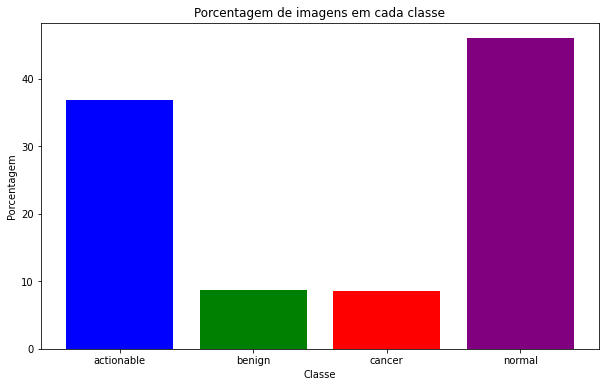

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable         160    36.781609
benign              38     8.735632
cancer              37     8.505747
normal             200    45.977011


In [6]:
#Validation set
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_paper_dataset\val'
plot_image_counts(folder_path)

Podemos perceber que mesmo se utilizarmos o training set com classificação binária, ainda teremos um desbalanceamento de dados muito elevado.

Vamos ver como está o training set da base de dados com data augmentation.

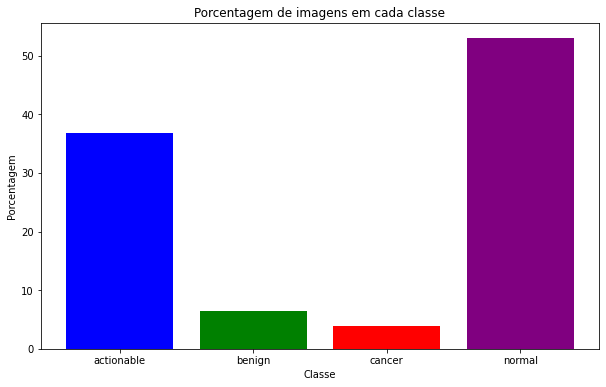

Tabela quantidade-porcentagem:
            Quantidade  Porcentagem
actionable        2848    36.715225
benign             496     6.394225
cancer             304     3.919041
normal            4109    52.971510


In [7]:
#Training set augmented
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\resized_and_augmentedCV2\train'
plot_image_counts(folder_path)

Aqui já é notável que se for feita uma classificação binária teremos um balanceamento maior. Vamos usar então o folder com data augmentation para realizar a classificação binária.

Fiz um novo folder manualmente chamado binary_augmented para isso.

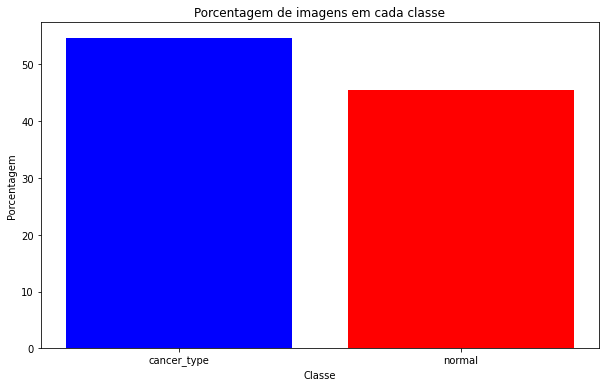

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         361    54.614221
normal              300    45.385779


In [8]:
#Test set binário
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\binary_augmented\test'
plot_image_counts2(folder_path)

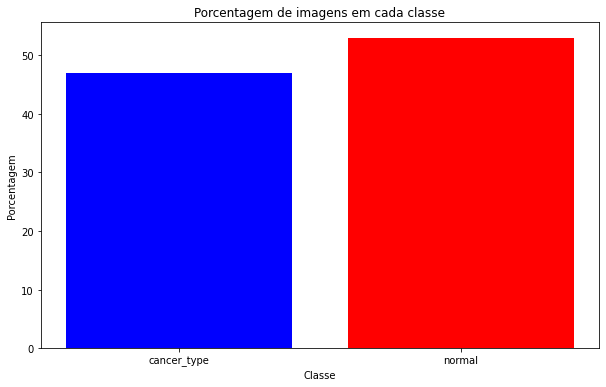

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type        3648     47.02849
normal             4109     52.97151


In [9]:
#Train set binário
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\binary_augmented\train'
plot_image_counts2(folder_path)

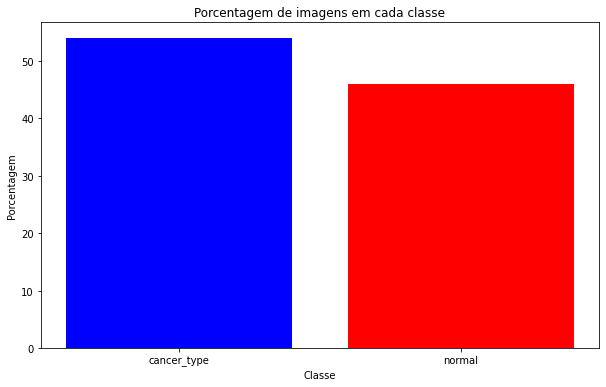

Tabela quantidade-porcentagem:
             Quantidade  Porcentagem
cancer_type         235    54.022989
normal              200    45.977011


In [10]:
#Vaildation set binário
folder_path = r'D:\Coisinhas\Coisas_UNB\TCC\binary_augmented\val'
plot_image_counts2(folder_path)

# 2 - Modelo usando DenseNet

Vou fazer também uma modificação no batch size, para 32, para ver como isso irá afetar a rede.

In [6]:
#Diretórios
train_dir = r'F:\Coisinhas\Coisas_UNB\TCC\binary_augmented\train'
val_dir = r'F:\Coisinhas\Coisas_UNB\TCC\binary_augmented\val'
test_dir = r'F:\Coisinhas\Coisas_UNB\TCC\binary_augmented\test'

#Set das dimensões
img_width, img_height = 1890//4, 2457//4 
input_shape = (img_width, img_height, 3)

#Batch size
batch_size = 32

#CLasses
num_classes = 4

In [7]:
#Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 7757 images belonging to 2 classes.
Found 435 images belonging to 2 classes.
Found 661 images belonging to 2 classes.


Uma coisa importante que também encontrei que pode ser importante para transfer learning:
https://stackoverflow.com/questions/49295311/what-is-the-difference-between-flatten-and-globalaveragepooling2d-in-keras

Em suma, usar global average pooling pode reduzir overfitting e também reduz os número de parâmetros para treinamento. Vamos ver o que acontece se eu usar ele em vez do flatten no final da rede.

Com o flatten no final:

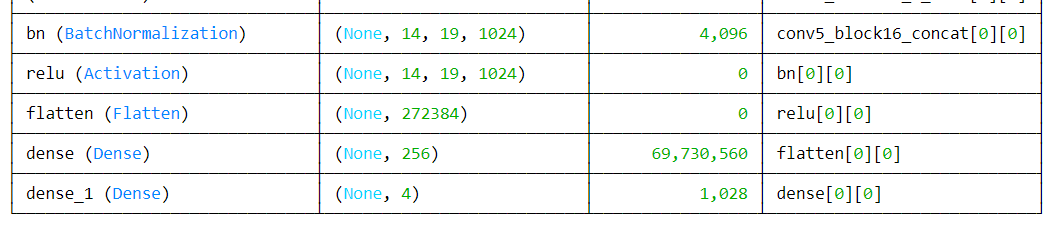

Com o pooling:
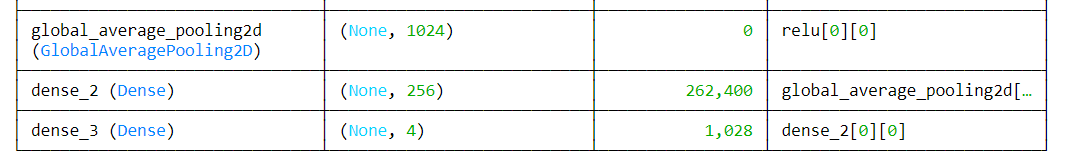

Convém testar os dois métodos, vou começar com o flatten pois era o que estava sendo usado anteriormente.

In [21]:
#Transfer learning com a densenet - flatten
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 4 classes
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=False)

In [25]:
#Treinamento
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


243/243 ━━━━━━━━━━━━━━━━━━━━ 5479s 22s/step - accuracy: 0.6399 - loss: 9.9661 - val_accuracy: 0.4874 - val_loss: 0.7487
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 3590s 15s/step - accuracy: 0.7311 - loss: 0.5091 - val_accuracy: 0.5333 - val_loss: 0.7554
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 3723s 15s/step - accuracy: 0.7582 - loss: 0.4783 - val_accuracy: 0.4920 - val_loss: 0.8992
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 6188s 25s/step - accuracy: 0.7827 - loss: 0.4368 - val_accuracy: 0.5080 - val_loss: 0.9072
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 4009s 16s/step - accuracy: 0.8007 - loss: 0.4159 - val_accuracy: 0.4874 - val_loss: 1.1768
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 3756s 15s/step - accuracy: 0.8238 - loss: 0.3764 - val_accuracy: 0.5172 - val_loss: 1.2450
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 3672s 15s/step - accuracy: 0.8448 - loss: 0.3365 - val_accuracy: 0.5241 - val_loss: 1.1853
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 4157s 17s/step - accuracy: 0.8833 - loss: 0.283

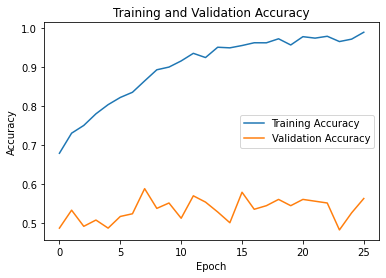

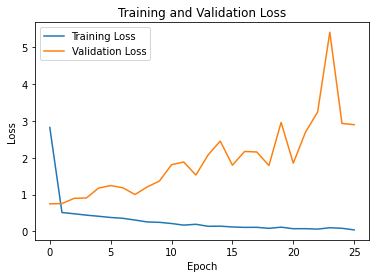

In [26]:
#Analise da precisao do treinamento e validacao
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [27]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

21/21 ━━━━━━━━━━━━━━━━━━━━ 329s 15s/step - accuracy: 0.5522 - loss: 2.8327
Test Accuracy: 54.01%
Test Loss: 3.0925


In [28]:
predictions = model.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

21/21 ━━━━━━━━━━━━━━━━━━━━ 362s 17s/step


array([0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,

In [29]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

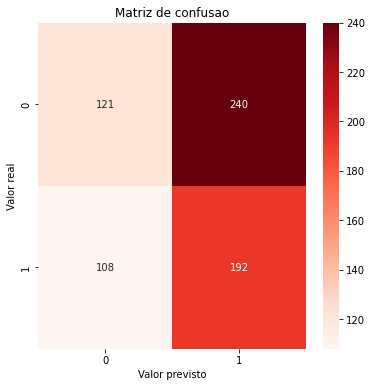

In [31]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(2), yticklabels=range(2))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [8]:
#Transfer learning com a densenet
base_model2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

#Congelando os pesos e trocando o último layer para nossas 4 classes
for layer in base_model2.layers:
    layer.trainable = False
    
x = GlobalAveragePooling2D()(base_model2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model2 = Model(inputs=base_model2.input, outputs=predictions)

In [9]:
#Compilar o modelo
adam = Adam(learning_rate=0.001)
model2.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
#Setup do early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=False)

In [ ]:
#Treinamento
history = model2.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[early_stopping])

Epoch 1/100


D:\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


243/243 ━━━━━━━━━━━━━━━━━━━━ 2349s 10s/step - accuracy: 0.6493 - loss: 0.6197 - val_accuracy: 0.4782 - val_loss: 0.7975
Epoch 2/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2308s 9s/step - accuracy: 0.6984 - loss: 0.5592 - val_accuracy: 0.5080 - val_loss: 0.7577
Epoch 3/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2317s 10s/step - accuracy: 0.7118 - loss: 0.5423 - val_accuracy: 0.5839 - val_loss: 0.6884
Epoch 4/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2325s 10s/step - accuracy: 0.7073 - loss: 0.5331 - val_accuracy: 0.5241 - val_loss: 0.7328
Epoch 5/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2344s 10s/step - accuracy: 0.7203 - loss: 0.5250 - val_accuracy: 0.4851 - val_loss: 0.7969
Epoch 6/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2336s 10s/step - accuracy: 0.7250 - loss: 0.5211 - val_accuracy: 0.5149 - val_loss: 0.7635
Epoch 7/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2336s 10s/step - accuracy: 0.7330 - loss: 0.5156 - val_accuracy: 0.4805 - val_loss: 0.8216
Epoch 8/100
243/243 ━━━━━━━━━━━━━━━━━━━━ 2342s 10s/step - accuracy: 0.7427 - loss: 0.5059

Infelizmente meu computador parou de rodar o código e acabei perdendo o treinamento que t inha sido realizado. Contudo, é perceptível que nos primeiros testes realizados a rede parece estar chutando entre as duas classficações. Isso me leva a acreditar que ou as imagens não estão sendo boas para a rede treinar (em seus tamanhoh que está sendo alimentado pela rede ou as imagens em si) ou a rede usada não está sendo boa.

Em relação ao segundo teste com o GlobalAveragePooling, pode-se perceber que, antes do meu computador parar de rodar o código, o treinamento estava bem lento, mas parecia estar indo melhor (e mais rápido) com que o flatten, a partir de uma análise de como tanto as losses e as accuracies dos dois casos estavam indo. Talvez seria bom testar um learning rate schedule com essa configuração para ver se ela consegue aprender de forma mais rápido (ou talvez ela tenha atingido um platô também).